<a href="https://colab.research.google.com/github/sergiomar73/nlp-google-colab/blob/main/Model_evaluation_against_STS_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install sentence_transformers datasets

In [21]:
from datasets import concatenate_datasets, load_dataset

In [22]:
dataset_train = load_dataset("stsb_multi_mt", name="en", split="train")
dataset_dev   = load_dataset("stsb_multi_mt", name="en", split="dev")
dataset_test  = load_dataset("stsb_multi_mt", name="en", split="test")

In [23]:
dataset_train

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 5749
})

In [24]:
dataset_dev

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1500
})

In [25]:
dataset_test

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1379
})

In [26]:
data = concatenate_datasets([dataset_train, dataset_dev, dataset_test])

In [27]:
def score(row):
    score = row["similarity_score"]
    if score >= 4.5:
        row["score"] = 5
    elif score >= 3.5:
        row["score"] = 4
    elif score >= 2.5:
        row["score"] = 3
    elif score >= 1.5:
        row["score"] = 2
    elif score >= 0.5:
        row["score"] = 1
    else:
        row["score"] = 0
    return row

In [28]:
data = data.map(score)

In [29]:
data

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score', 'score'],
    num_rows: 8628
})

In [30]:
data[0]

{'sentence1': 'A plane is taking off.',
 'sentence2': 'An air plane is taking off.',
 'similarity_score': 5.0,
 'score': 5}

In [31]:
data[-1]

{'sentence1': 'South Korea declares end to MERS outbreak',
 'sentence2': 'North Korea Delegation Meets With South Korean Officials',
 'similarity_score': 0.0,
 'score': 0}

In [32]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
import torch

In [34]:
model1 = SentenceTransformer('thenlper/gte-base')

In [53]:
def similarity(row, model):
    embeddings = model.encode([ row["sentence1"], row["sentence2"] ])
    row["cosine"] = cos_sim(embeddings[0], embeddings[1]).item()
    t1 = torch.from_numpy(embeddings[0])
    t2 = torch.from_numpy(embeddings[1])
    row["l2_torch"] = torch.dist(t1, t2, p=2)
    # np1 = embeddings[0].detach().cpu().numpy()
    # np2 = embeddings[1].detach().cpu().numpy()
    row["l2_numpy"] = np.linalg.norm(embeddings[0] - embeddings[1])
    return row

In [54]:
# df1 = data.select(range(10)).map(similarity)
df1 = data.select(range(10)).map(similarity, fn_kwargs={"model": model1})

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [40]:
df1

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score', 'score', 'cosine', 'l2_numpy'],
    num_rows: 10
})

In [55]:
df1[0]

{'sentence1': 'A plane is taking off.',
 'sentence2': 'An air plane is taking off.',
 'similarity_score': 5.0,
 'score': 5,
 'cosine': 0.9832922220230103,
 'l2_torch': 0.18279965221881866,
 'l2_numpy': 0.18279963731765747}

In [56]:
df1[1]

{'sentence1': 'A man is playing a large flute.',
 'sentence2': 'A man is playing a flute.',
 'similarity_score': 3.799999952316284,
 'score': 4,
 'cosine': 0.9596573710441589,
 'l2_torch': 0.2840515971183777,
 'l2_numpy': 0.2840515971183777}

In [60]:
df1[8627]

{'sentence1': 'A person is throwing a cat on to the ceiling.',
 'sentence2': 'A person throws a cat on the ceiling.',
 'similarity_score': 5.0,
 'score': 5,
 'cosine': 0.9921689629554749,
 'l2_torch': 0.12514889240264893,
 'l2_numpy': 0.12514889240264893}

In [57]:
import plotly.express as px
fig = px.scatter(df1, x="similarity_score", y="l2_numpy", size="score", color="score", trendline="ols")
fig.show()

In [ ]:
df1.to_csv("gte-base.csv")

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

1243789

In [45]:
import pandas as pd

In [46]:
pd1 = pd.DataFrame(df1)

In [ ]:
# bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

In [ ]:
# groups1 = pd1.groupby(['score', pd.cut(pd1.similarity, bins)])
# gr1 = groups1.size().unstack()

In [ ]:
# gr1

similarity,"(0.0, 0.05]","(0.05, 0.1]","(0.1, 0.15]","(0.15, 0.2]","(0.2, 0.25]","(0.25, 0.3]","(0.3, 0.35]","(0.35, 0.4]","(0.4, 0.45]","(0.45, 0.5]","(0.5, 0.55]","(0.55, 0.6]","(0.6, 0.65]","(0.65, 0.7]","(0.7, 0.75]","(0.75, 0.8]","(0.8, 0.85]","(0.85, 0.9]","(0.9, 0.95]","(0.95, 1.0]"
score,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,46,174,335,317,115,19,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,19,112,386,458,247,43,5
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,12,68,311,644,323,41
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,7,100,600,1043,253
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,161,903,952
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,151,749


In [ ]:
# gr1.columns

CategoricalIndex([(0.0, 0.05], (0.05, 0.1], (0.1, 0.15], (0.15, 0.2],
                  (0.2, 0.25], (0.25, 0.3], (0.3, 0.35], (0.35, 0.4],
                  (0.4, 0.45], (0.45, 0.5], (0.5, 0.55], (0.55, 0.6],
                  (0.6, 0.65], (0.65, 0.7], (0.7, 0.75], (0.75, 0.8],
                  (0.8, 0.85], (0.85, 0.9], (0.9, 0.95], (0.95, 1.0]],
                 categories=[(0.0, 0.05], (0.05, 0.1], (0.1, 0.15], (0.15, 0.2], ..., (0.8, 0.85], (0.85, 0.9], (0.9, 0.95], (0.95, 1.0]], ordered=True, dtype='category', name='similarity')

<Axes: xlabel='score'>

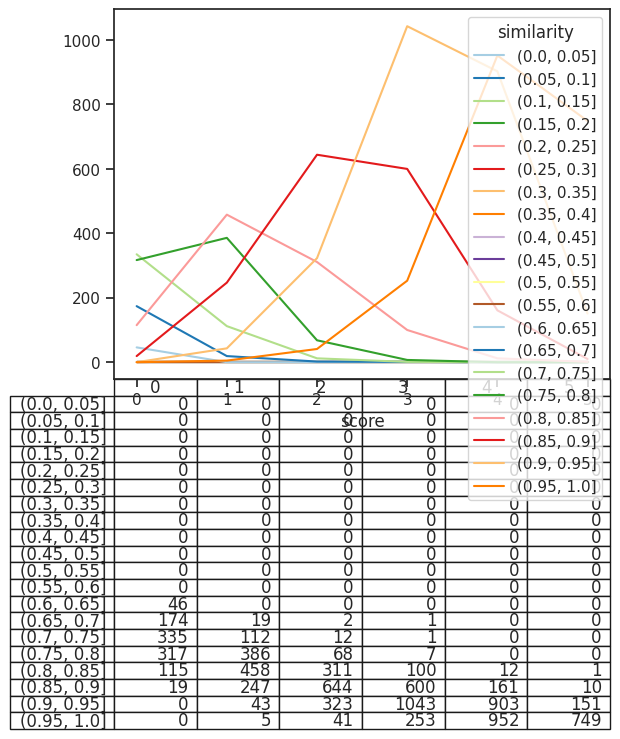

In [ ]:
# gr1.plot(table=True)

In [ ]:
# sns.boxplot(x="score", y="similarity", hue="score", data=gr1)
# sns.despine(offset=10, trim=True)

In [43]:
import seaborn as sns
sns.set_theme(style="ticks", palette="Paired")

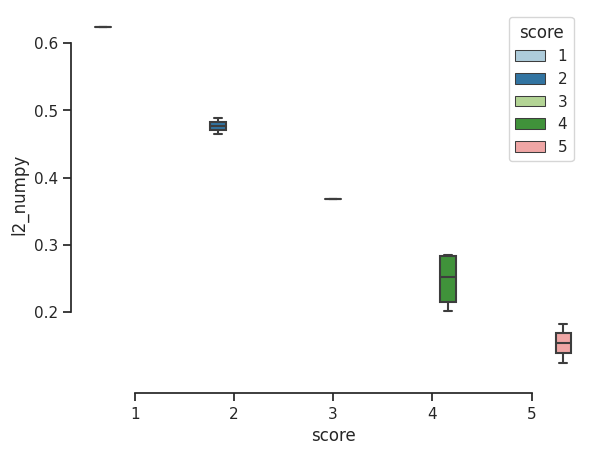

In [58]:
sns.boxplot(x="score", y="l2_numpy", hue="score", data=pd1)
sns.despine(offset=10, trim=True)

In [ ]:
model2 = SentenceTransformer('paraphrase-distilroberta-base-v2')

In [ ]:
df2 = data.map(similarity, fn_kwargs={"model": model2}, num_proc=4)

Map (num_proc=4):   0%|          | 0/8628 [00:00<?, ? examples/s]

In [ ]:
df2

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score', 'score', 'similarity'],
    num_rows: 8628
})

In [ ]:
df2[0]

{'sentence1': 'A plane is taking off.',
 'sentence2': 'An air plane is taking off.',
 'similarity_score': 5.0,
 'score': 5,
 'similarity': 0.9506030082702637}

In [ ]:
df2[1]

{'sentence1': 'A man is playing a large flute.',
 'sentence2': 'A man is playing a flute.',
 'similarity_score': 3.799999952316284,
 'score': 4,
 'similarity': 0.8776326179504395}

In [ ]:
df2[8627]

{'sentence1': 'South Korea declares end to MERS outbreak',
 'sentence2': 'North Korea Delegation Meets With South Korean Officials',
 'similarity_score': 0.0,
 'score': 0,
 'similarity': 0.2793128490447998}

In [ ]:
import plotly.express as px
fig = px.scatter(df2, x="similarity_score", y="l2_numpy", size="score", color="score", trendline="ols")
fig.show()

In [ ]:
pd2 = pd.DataFrame(df2)

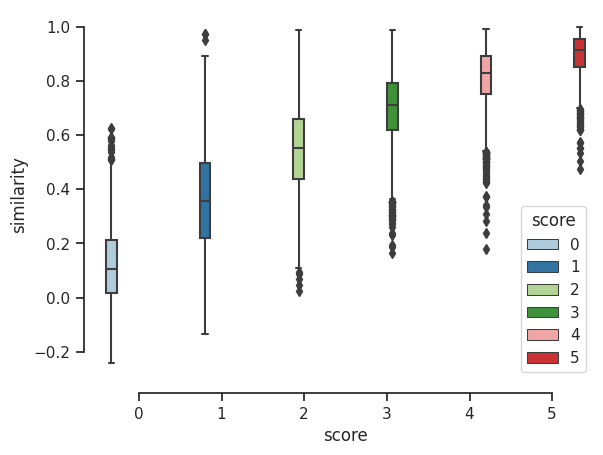

In [ ]:
sns.boxplot(x="score", y="l2_numpy", hue="score", data=pd2)
sns.despine(offset=10, trim=True)

In [ ]:
df2.to_csv("paraphrase-distilroberta-base-v2.csv")

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

1246190

In [ ]:
model3 = SentenceTransformer('sentence-transformers/sentence-t5-base')

In [ ]:
df3 = data.map(similarity, fn_kwargs={"model": model3})

Map:   0%|          | 0/8628 [00:00<?, ? examples/s]

In [ ]:
df3[0]

{'sentence1': 'A plane is taking off.',
 'sentence2': 'An air plane is taking off.',
 'similarity_score': 5.0,
 'score': 5,
 'similarity': 0.9891976118087769}

In [ ]:
df3[1]

{'sentence1': 'A man is playing a large flute.',
 'sentence2': 'A man is playing a flute.',
 'similarity_score': 3.799999952316284,
 'score': 4,
 'similarity': 0.9436050057411194}

In [ ]:
df3[8627]

{'sentence1': 'South Korea declares end to MERS outbreak',
 'sentence2': 'North Korea Delegation Meets With South Korean Officials',
 'similarity_score': 0.0,
 'score': 0,
 'similarity': 0.7914119958877563}

In [ ]:
import plotly.express as px
fig3 = px.scatter(df3, x="similarity_score", y="l2_numpy", size="score", color="score", trendline="ols")
fig3.show()

In [ ]:
df3.to_csv('sentence-t5-base.csv')

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

1243859

In [ ]:
pd3 = pd.DataFrame(df3)

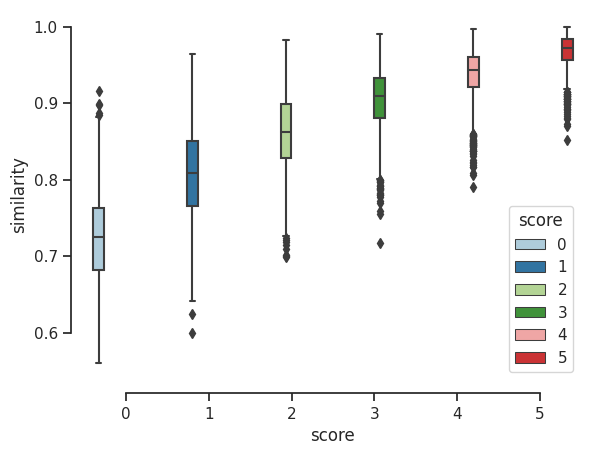

In [ ]:
sns.boxplot(x="score", y="l2_numpy", hue="score", data=pd3)
sns.despine(offset=10, trim=True)

In [ ]:
model4 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
df4 = data.map(similarity, fn_kwargs={"model": model4})

Map:   0%|          | 0/8628 [00:00<?, ? examples/s]

In [ ]:
df4[0]

{'sentence1': 'A plane is taking off.',
 'sentence2': 'An air plane is taking off.',
 'similarity_score': 5.0,
 'score': 5,
 'similarity': 0.9596577882766724}

In [ ]:
df4[1]

{'sentence1': 'A man is playing a large flute.',
 'sentence2': 'A man is playing a flute.',
 'similarity_score': 3.799999952316284,
 'score': 4,
 'similarity': 0.8690923452377319}

In [ ]:
df4[8627]

{'sentence1': 'South Korea declares end to MERS outbreak',
 'sentence2': 'North Korea Delegation Meets With South Korean Officials',
 'similarity_score': 0.0,
 'score': 0,
 'similarity': 0.3166734576225281}

In [ ]:
df4.to_csv('all-mpnet-base-v2.csv')

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

1245804

In [ ]:
pd4 = pd.DataFrame(df4)

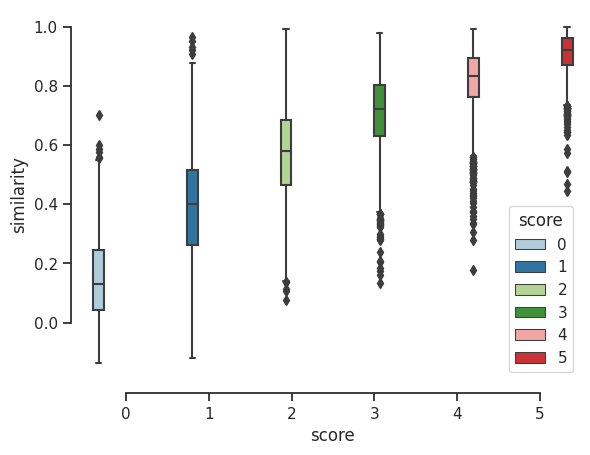

In [ ]:
sns.boxplot(x="score", y="l2_numpy", hue="score", data=pd4)
sns.despine(offset=10, trim=True)

In [ ]:
import plotly.express as px
fig4 = px.scatter(df4, x="similarity_score", y="l2_numpy", size="score", color="score", trendline="ols")
fig4.show()